In [1]:
# Import python libraries
#
import importlib
import pickle
import os
import torch

# Go one directory back, because all imports are done
# relative to the root of the project.
#
project_root = '..'
if 'change_directory_to_root' not in globals():
    change_directory_to_root = True
    os.chdir(project_root)

# Imports own modules.
#
import scripts.Visualization as Visualization
import scripts.ModelTrainer as ModelTrainer
import scripts.Utils as utils
import scripts.Simulation_config as Simulation_config
from scripts.Simulation_config import *
import scripts.Model as model
import scripts.ModelAdapter as ModelAdapter


/home/molu/miniconda3/envs/xlstm/lib/python3.11/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /opt/conda/conda-bld/pytorch_1704987288773/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
No CUDA runtime is found, using CUDA_HOME='/home/molu/miniconda3/envs/xlstm'


In [ ]:
importlib.reload(model)
importlib.reload(ModelTrainer)
importlib.reload(Simulation_config)
importlib.reload(utils)

# Run the whole simulation
#
train_all_models = False
if train_all_models:
    configs = Simulation_config.configs
    ModelTrainer.ModelTrainer().run(configs)

# Print the sumarized simulation results
#
utils.Evaluate_Models.print_results('scripts/outputs/all_train_histories.pkl')




Do Data Preprocessing for run config=Config_of_one_run(modelSize='MEDIUM', doPretraining=True, doTransferLearning=True, aggregation_Count='data/london_loadprofiles_37households_each.pkl', nrOfComunities=20, trainingHistory=466, modelInputHistory=24, usedModels=('SyntheticLoadProfile', 'KNN', 'PersistencePrediction', 'xLSTM', 'LSTM', 'Transformer'), epochs=100).



Pretraining SyntheticLoadProfile model and and sim_config 1/8.

Pretraining KNN model and and sim_config 1/8.

Pretraining PersistencePrediction model and and sim_config 1/8.

Pretraining xLSTM model and and sim_config 1/8.


RuntimeError: mat1 and mat2 must have the same dtype, but got Double and Float

In [11]:
# Plot the losses over the training.
# (To see, if the models are trained stable.)
#
importlib.reload(utils)

plot_only_single_config = True
plotted_config = Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._37_HOUSEHOLDS, 
    NrOfComunities._20, TrainingHistory._2_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT)

utils.Evaluate_Models.plot_training_losses_over_epochs('scripts/outputs/all_train_histories.pkl',
                                                       plot_only_single_config,
                                                       plotted_config
                                                       )


Plotted Config:
("Config_of_one_run(modelSize='MEDIUM', doPretraining=True, "
 'doTransferLearning=True, '
 "aggregation_Count='data/london_loadprofiles_37households_each.pkl', "
 'nrOfComunities=20, trainingHistory=61, modelInputHistory=24, '
 "usedModels=('SyntheticLoadProfile', 'KNN', 'PersistencePrediction', 'xLSTM', "
 "'LSTM', 'Transformer'), epochs=100)")


In [4]:
# Evaluate specific model of given power profiles and given configurations
#

importlib.reload(Visualization)
importlib.reload(model)
importlib.reload(utils)
importlib.reload(ModelAdapter)

# Define a specific configuration
#
test_profile = "scripts/outputs/file_0.pkl"
with open(test_profile, 'rb') as f:
    (X, Y, modelAdapter) = pickle.load(f)
path_to_trained_parameters = 'scripts/outputs/all_trained_models.pth'
model_type = 'SyntheticLoadProfile'
num_of_features = X['train'].shape[2]
myConfig = Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._37_HOUSEHOLDS, 
                NrOfComunities._20, TrainingHistory._2_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT)

# Plot the chosen model
#
myModel = utils.Deserialize.get_trained_model(path_to_trained_parameters, model_type, test_profile, myConfig, num_of_features)
plotlyApp = Visualization.PlotlyApp(X, Y, myModel, modelAdapter, None, 'UTC')
plotlyApp.run(myport=8060)


Address already in use
Port 8060 is in use by another program. Either identify and stop that program, or start the server with a different port.


SystemExit: 1

/home/molu/miniconda3/envs/xlstm/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3585: UserWarning:

To exit: use 'exit', 'quit', or Ctrl-D.



In [40]:
# Store specific predictions, for the paper 'use case' section.
#

import numpy as np
importlib.reload(model)
importlib.reload(utils)

# Define a specific configuration
#
test_profile = "scripts/outputs/file_0.pkl"
with open(test_profile, 'rb') as f:
    (X, Y, modelAdapter) = pickle.load(f)
path_to_trained_parameters = 'scripts/outputs/all_trained_models_20241107_0520.pth'
num_of_features = X['train'].shape[2]
myConfig = Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._37_HOUSEHOLDS, 
                NrOfComunities._20, TrainingHistory._15_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT)
P_el_predicted = modelAdapter.deNormalizeY(Y['test']).flatten().unsqueeze(0)

# Store the predicted power profiles
#
for model_type in Simulation_config.UsedModels.ALL:
    my_Model = utils.Deserialize.get_trained_model(path_to_trained_parameters, model_type, test_profile, myConfig, num_of_features)
    Y_pred = torch.Tensor(modelAdapter.deNormalizeY(my_Model.predict(X['test'], Y['test'])).flatten())
    P_el_predicted = torch.cat([P_el_predicted, Y_pred.unsqueeze(0)], dim=0)    

startdate = modelAdapter.getStartDateFromIndex('test', 0)
file_path = "scripts/outputs/example_predictions.pkl"
with open(file_path, 'wb') as file:
    pickle.dump((P_el_predicted, startdate), file)

print(P_el_predicted.shape)
print(startdate)


torch.Size([7, 3144])
2013-10-20 00:00:00+00:00


In [ ]:
# Print the model parameter sizes
#

importlib.reload(model)

model_types = ['xLSTM', 'LSTM', 'Transformer']
for model_type in model_types:
    for model_size in ['SMALL', 'MEDIUM', 'LARGE']:

        # Test, if the model is run-able
        num_of_features = 18
        m = model.Model(model_type, model_size, num_of_features)
        x = torch.zeros((7, 24*22, num_of_features))
        m.my_model(x)

        # Print the model's parameter count
        nr_of_parameters = m.get_nr_of_parameters(do_print=False)
        print(f"{model_type} - {model_size} has {nr_of_parameters} parameters.")


xLSTM - SMALL has 19791 parameters.
xLSTM - MEDIUM has 26411 parameters.
xLSTM - LARGE has 97679 parameters.
LSTM - SMALL has 17463 parameters.
LSTM - MEDIUM has 44031 parameters.
LSTM - LARGE has 104831 parameters.
Transformer - SMALL has 24423 parameters.
Transformer - MEDIUM has 50863 parameters.
Transformer - LARGE has 113351 parameters.


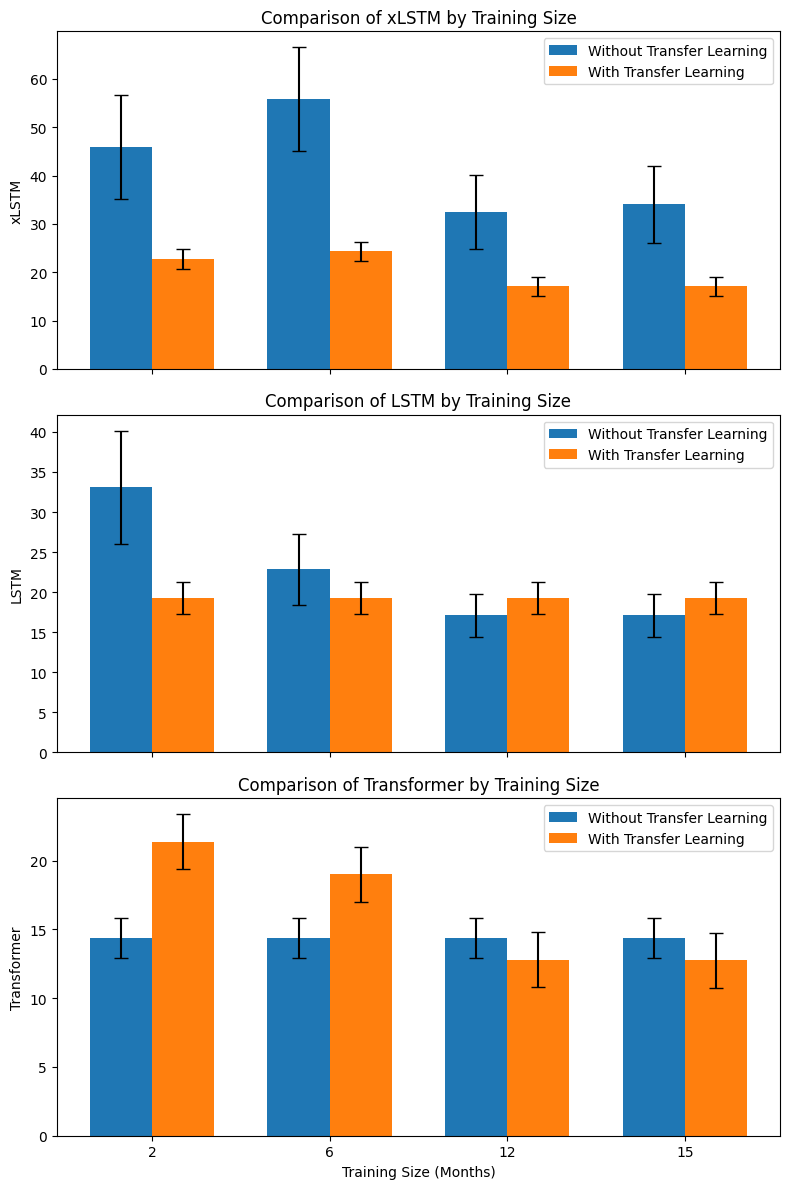

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Updating the data to include standard deviation values
data_with_transfer = {
    'Training Size (mo)': ['2', '6', '12', '15'],
    'xLSTM': [45.96, 55.80, 32.41, 34.05],
    'xLSTM Std': [10.73, 10.72, 7.69, 7.92],
    'LSTM': [33.10, 22.83, 17.11, 17.13],
    'LSTM Std': [7.04, 4.42, 2.66, 2.69],
    'Transformer': [14.39, 14.39, 14.39, 14.39],
    'Transformer Std': [1.45, 1.45, 1.45, 1.45]
}

data_without_transfer = {
    'Training Size (mo)': ['2', '6', '12', '15'],
    'xLSTM': [22.73, 24.34, 17.09, 17.11],
    'xLSTM Std': [2, 2, 2, 2],
    'LSTM': [19.30, 19.30, 19.30, 19.30],
    'LSTM Std': [2, 2, 2, 2],
    'Transformer': [21.38, 19.01, 12.78, 12.77],
    'Transformer Std': [2, 2, 2, 2]
}

# Convert dictionaries to DataFrames
df_with_transfer = pd.DataFrame(data_with_transfer)
df_without_transfer = pd.DataFrame(data_without_transfer)

# Define the positions for bars to display them side-by-side
bar_width = 0.35  # Width of each bar
x = np.arange(len(df_with_transfer['Training Size (mo)']))  # The label locations

fig, axs = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

# Titles for each column
titles = ["xLSTM", "LSTM", "Transformer"]

# Plot each column in a separate subplot with error bars
for i, col in enumerate(['xLSTM', 'LSTM', 'Transformer']):
    std_col_with = f"{col} Std"
    std_col_without = f"{col} Std"
    
    axs[i].bar(x - bar_width/2, df_with_transfer[col], width=bar_width, yerr=df_with_transfer[std_col_with], 
               capsize=5, label='Without Transfer Learning')
    axs[i].bar(x + bar_width/2, df_without_transfer[col], width=bar_width, yerr=df_without_transfer[std_col_without], 
               capsize=5, label='With Transfer Learning')
    
    axs[i].set_ylabel(titles[i])
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(df_with_transfer['Training Size (mo)'])
    axs[i].legend()
    axs[i].set_title(f"Comparison of {titles[i]} by Training Size")

# Set common X label
plt.xlabel("Training Size (Months)")
plt.tight_layout()
plt.show()



In [ ]:
df_with_transfer

,Training Size (mo),xLSTM,xLSTM Std,LSTM,LSTM Std,Transformer,Transformer Std
0,2,45.96,10.73,33.10,7.04,14.39,1.45
1,6,55.80,10.72,22.83,4.42,14.39,1.45
2,12,32.41,7.69,17.11,2.66,14.39,1.45
3,15,34.05,7.92,17.13,2.69,14.39,1.45
